In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('fmcg.csv', index_col=['date'])
prices.head(10)

HINDUNILVR.NS      ITC.NS  NESTLEIND.NS  TATACONSUM.NS  \
date                                                                 
01-01-2018    1344.500000  262.299988   7863.200195     312.899994   
02-01-2018    1338.599976  260.750000   7863.549805     311.149994   
03-01-2018    1350.349976  261.149994   7860.100098     311.200012   
04-01-2018    1352.250000  261.549988   7869.250000     312.250000   
05-01-2018    1356.550049  262.899994   7856.750000     312.950012   
08-01-2018    1368.400024  265.600006   7941.149902     317.600006   
09-01-2018    1361.300049  270.549988   7779.250000     315.299988   
10-01-2018    1365.800049  269.399994   7846.649902     314.100006   
11-01-2018    1378.650024  269.799988   7874.299805     313.299988   
12-01-2018    1374.000000  267.549988   7789.250000     325.750000   

            BRITANNIA.NS  GODREJCP.NS    DABUR.NS  MCDOWELL-N.NS   MARICO.NS  \
date                                                                           
01-01-2018   2369.125000   657.500000  349.000000     728.760010  320.700012   
02-01-2018   2328.024902   654.366638  349.049988     718.400024  325.700012   
03-01-2018   2340.475098   657.599976  354.649994     719.630005  320.850006   
04-01-2018   2313.199951   659.633362  355.000000     737.770019  323.350006   
05-01-2018   2322.050049   660.033325  358.200012     790.650024  326.950012   
08-01-2018   2346.875000   663.133362  361.350006     784.700012  323.149994   
09-01-2018   2320.975098   658.833313  359.350006     768.909973  323.850006   
10-01-2018   2337.375000   652.299988  357.799988     766.080017  321.649994   
11-01-2018   2360.774902   656.666687  359.899994     765.530029  316.299988   
12-01-2018   2354.149902   660.866638  358.149994     761.849976  312.700012   

              COLPAL.NS  
date                     
01-01-2018  1102.599976  
02-01-2018  1100.750000  
03-01-2018  1098.349976  
04-01-2018  1094.349976  
05-01-2018  1100.699951  
08-01-2018  1117.699951  
09-01-2018  1120.599976  
10-01-2018  1118.250000  
11-01-2018  1125.050049  
12-01-2018  1139.599976

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

HINDUNILVR.NS      ITC.NS  NESTLEIND.NS  TATACONSUM.NS  \
date                                                                 
01-01-2018    1344.500000  262.299988   7863.200195     312.899994   
02-01-2018    1338.599976  260.750000   7863.549805     311.149994   
30-12-2020    2406.600098  211.149994  18379.250000     594.349976   
31-12-2020    2395.399902  209.000000  18390.250000     589.900024   

            BRITANNIA.NS  GODREJCP.NS    DABUR.NS  MCDOWELL-N.NS   MARICO.NS  \
date                                                                           
01-01-2018   2369.125000   657.500000  349.000000     728.760010  320.700012   
02-01-2018   2328.024902   654.366638  349.049988     718.400024  325.700012   
30-12-2020   3583.899902   749.150024  539.549988     577.750000  403.450012   
31-12-2020   3576.350098   740.150024  534.000000     578.250000  402.649994   

              COLPAL.NS  
date                     
01-01-2018  1102.599976  
02-01-2018  1100.750000  
30-12-2020  1579.000000  
31-12-2020  1565.250000

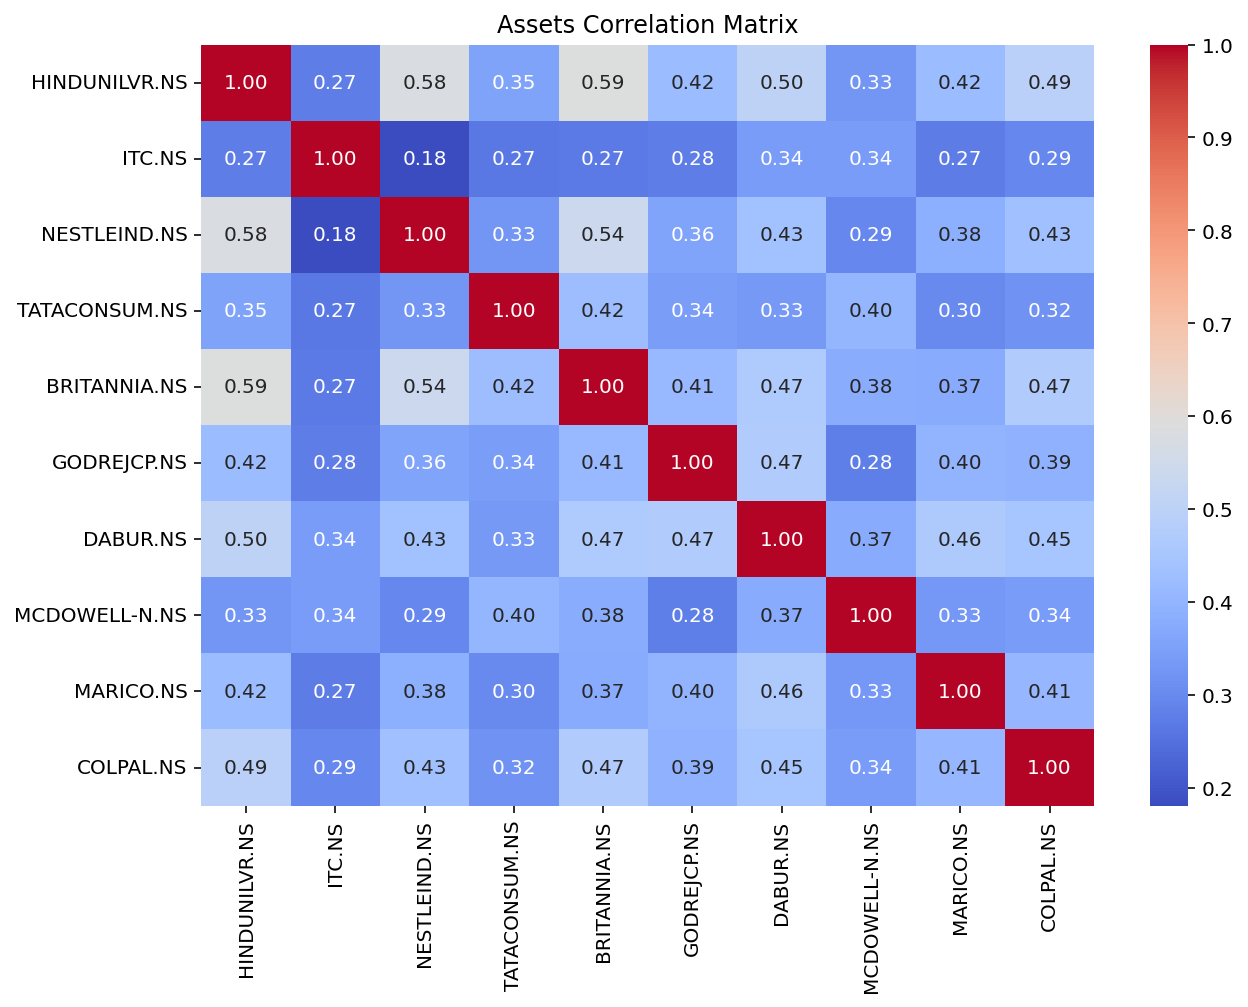

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('HINDUNILVR.NS', 'NESTLEIND.NS'), ('HINDUNILVR.NS', 'DABUR.NS'), ('MCDOWELL-N.NS', 'MARICO.NS'), ('MCDOWELL-N.NS', 'COLPAL.NS')]


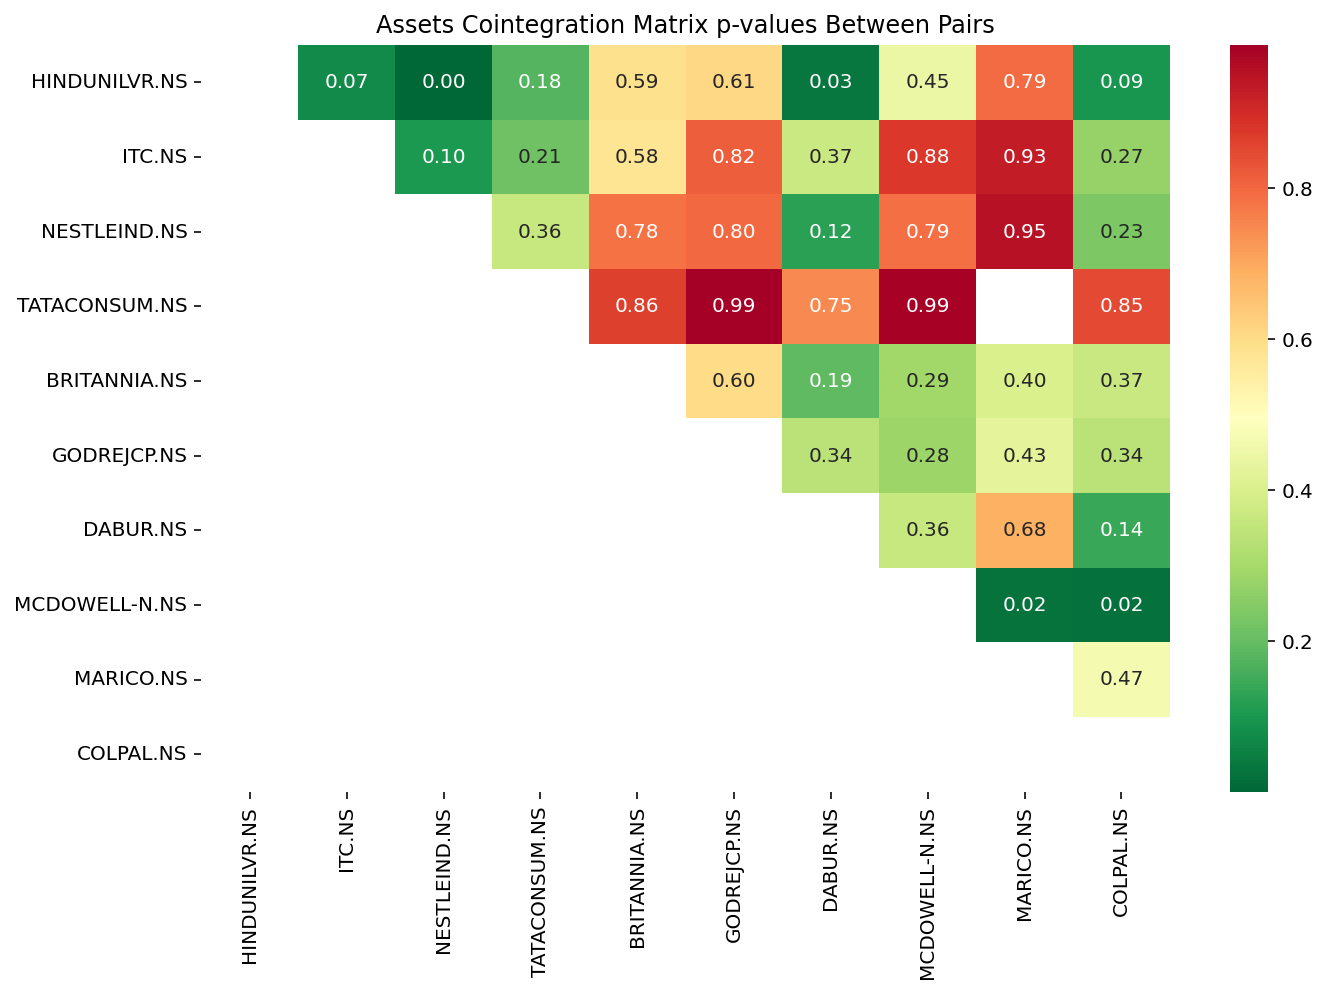

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'HINDUNILVR.NS'
asset2 = 'DABUR.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

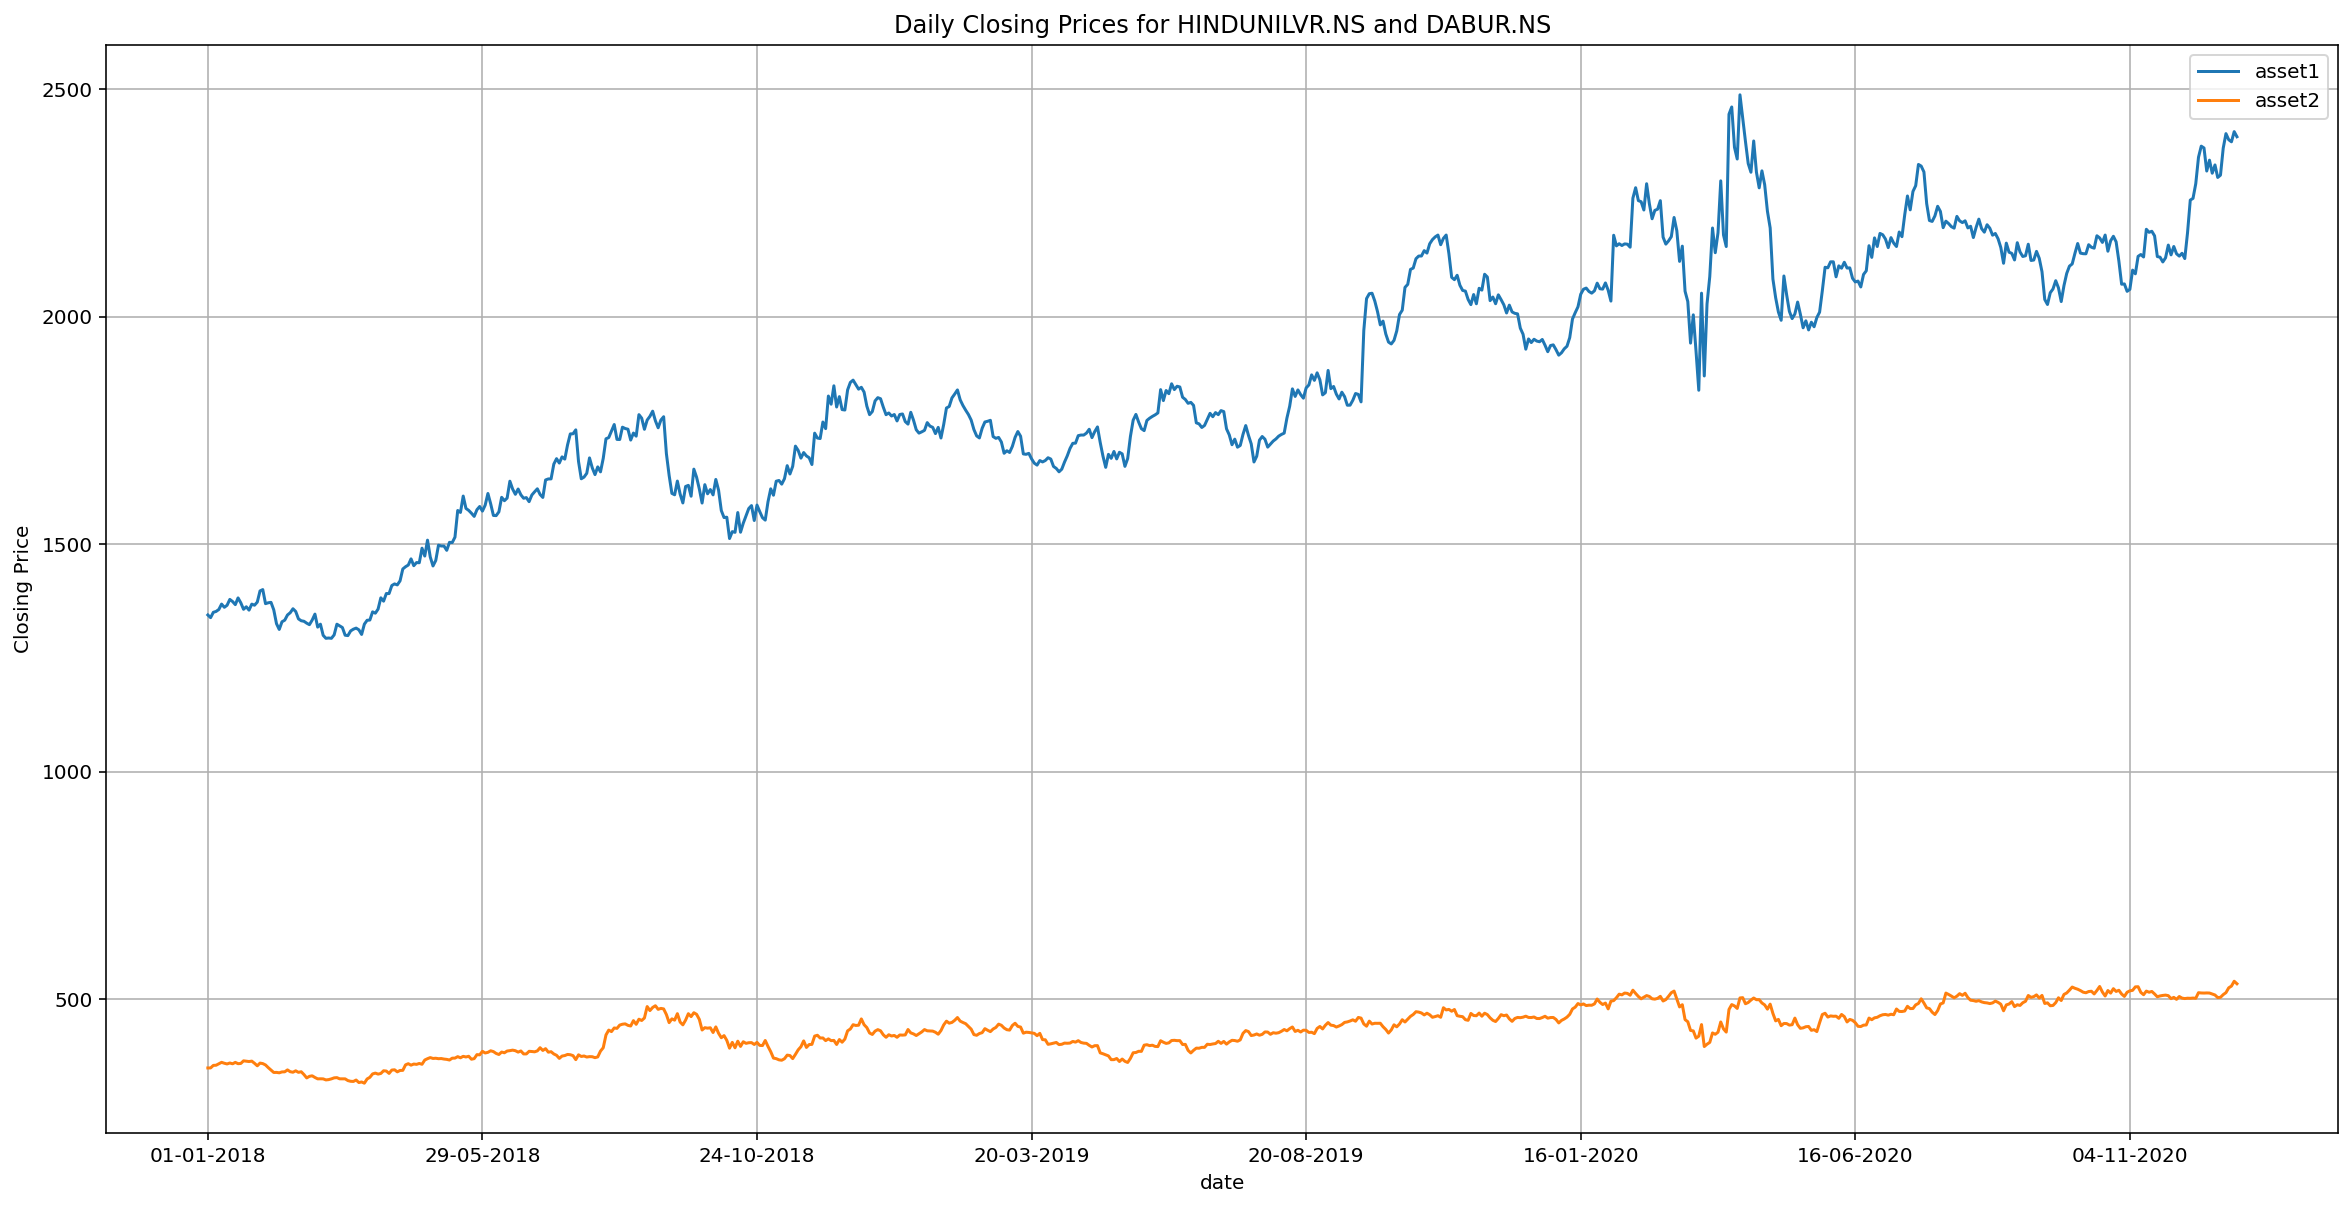

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.656e+05
Date:                Sun, 20 Mar 2022   Prob (F-statistic):                        0.00
Time:                        21:48:16   Log-Likelihood:                         -3546.0
No. Observations:                 740   AIC:                                      7094.
Df Residuals:                     739   BIC:                                      7099.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.2328      0.001    406.933      0.000       0.232       0.234
==============================================================================
Omnibus:                        4.220   Durbin-Watson:                   0.062
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                4.772
Skew:                          -0.072   Prob(JB):                       0.0920
Kurtosis:                       3.366   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

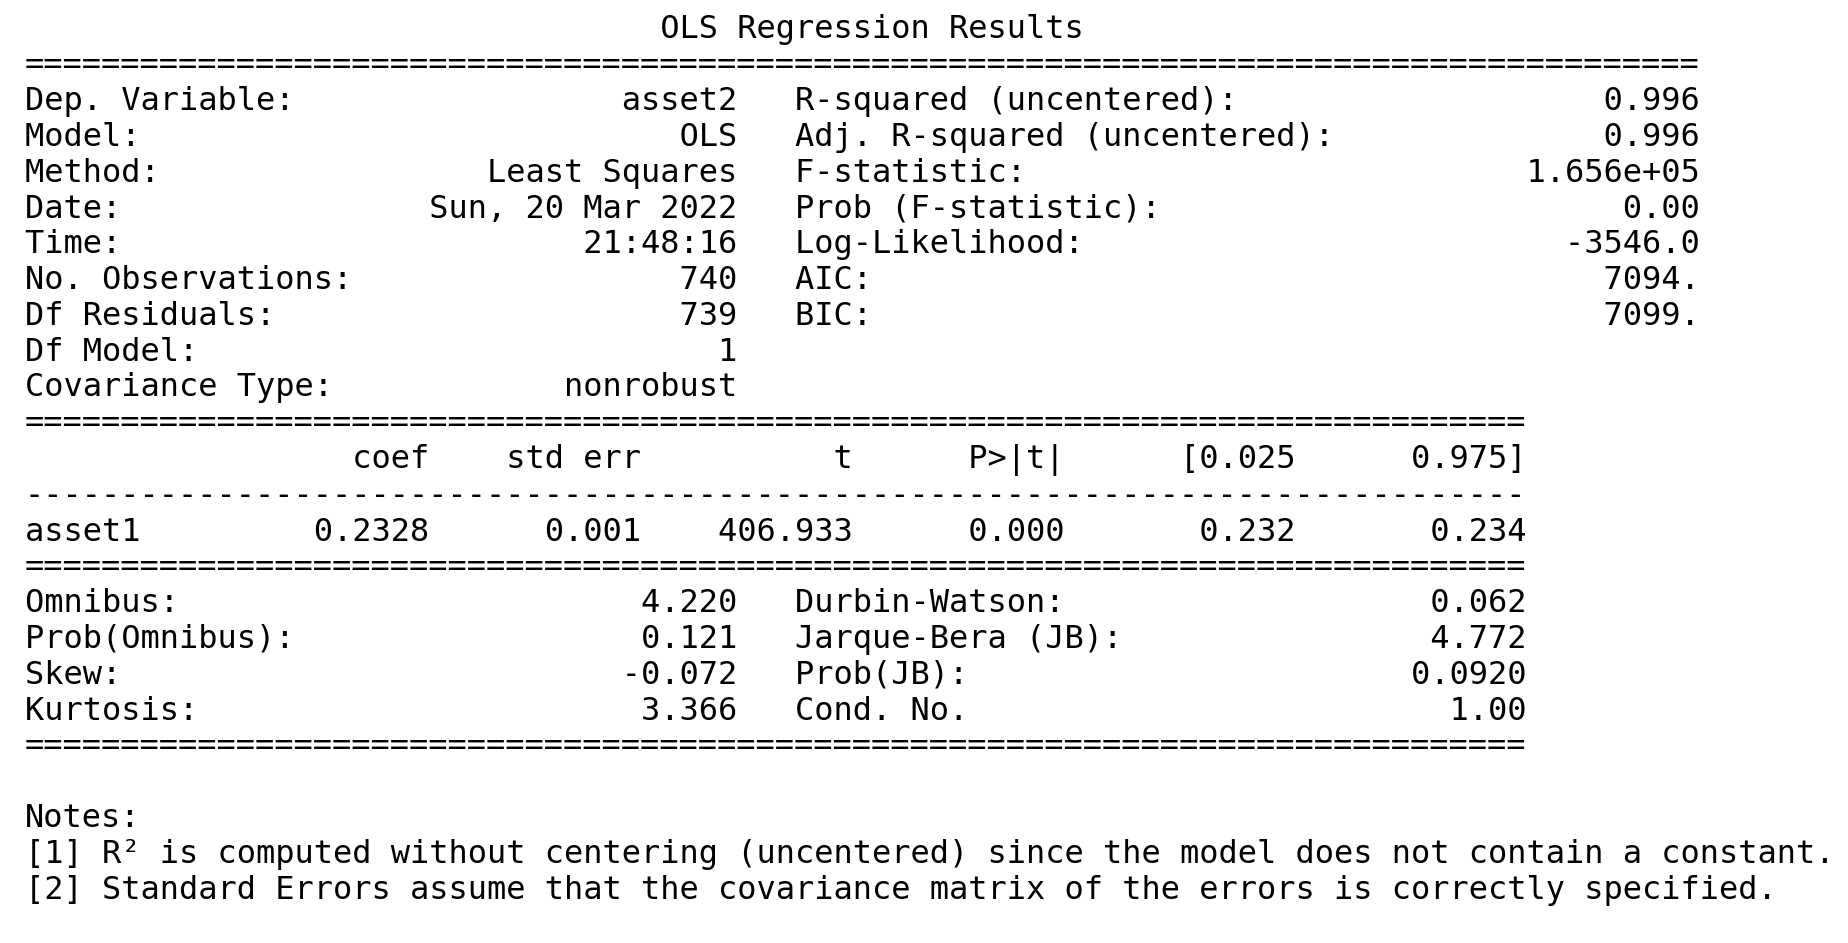

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.23276152762244762


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

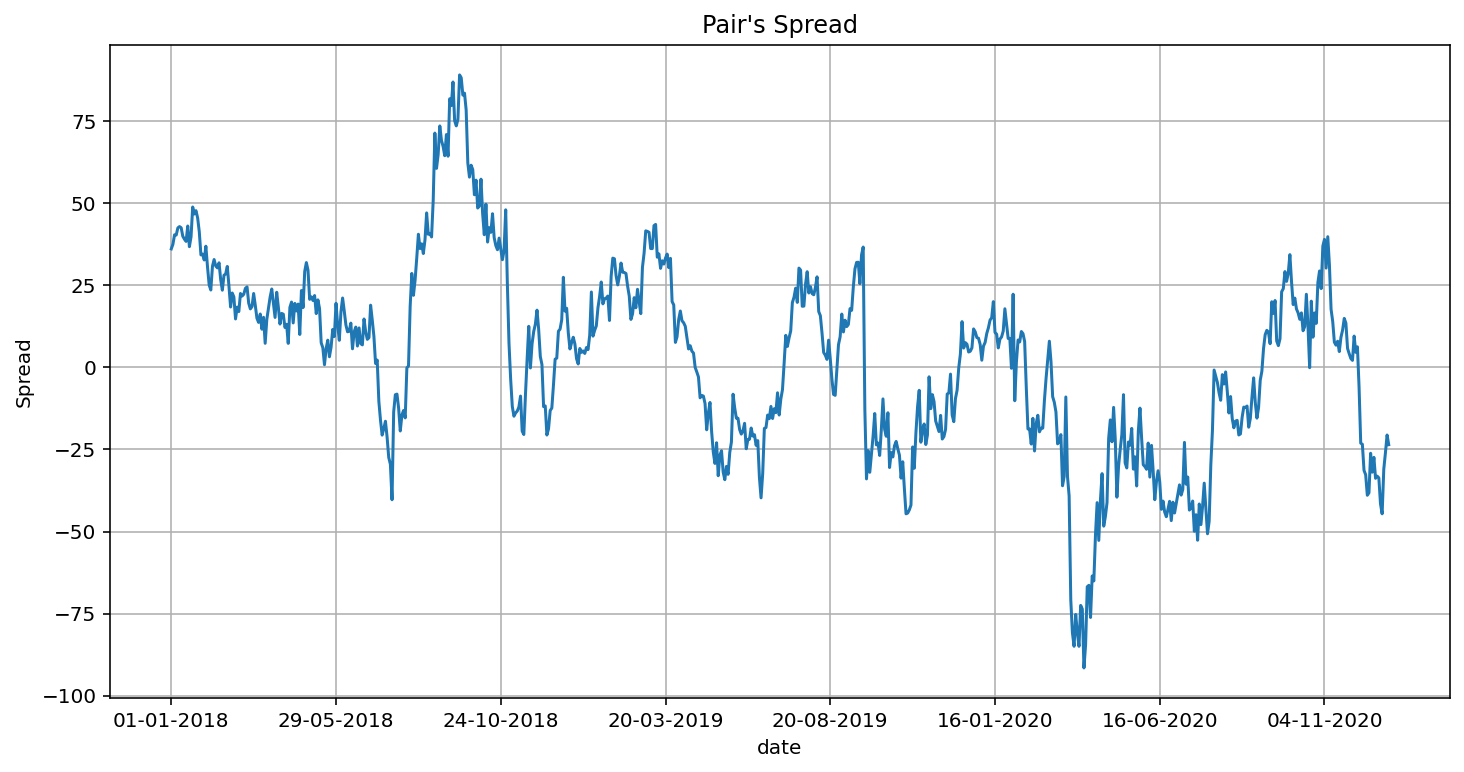

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.2059735279338706,
 0.019641501294943478,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 5013.45238613929)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -3.2059735279338706


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                               
01-01-2021  2387.550049  534.200012
04-01-2021  2426.500000  543.349976
05-01-2021  2450.550049  538.900024
06-01-2021  2417.300049  534.099976
07-01-2021  2368.850098  535.200012

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                       
01-01-2021  2387.550049  534.200012  1.372804            1.0           -1.0
04-01-2021  2426.500000  543.349976  1.351348            1.0           -1.0
05-01-2021  2450.550049  538.900024  1.839906            1.0           -1.0
06-01-2021  2417.300049  534.099976  1.711709            1.0           -1.0
07-01-2021  2368.850098  535.200012  1.113307            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

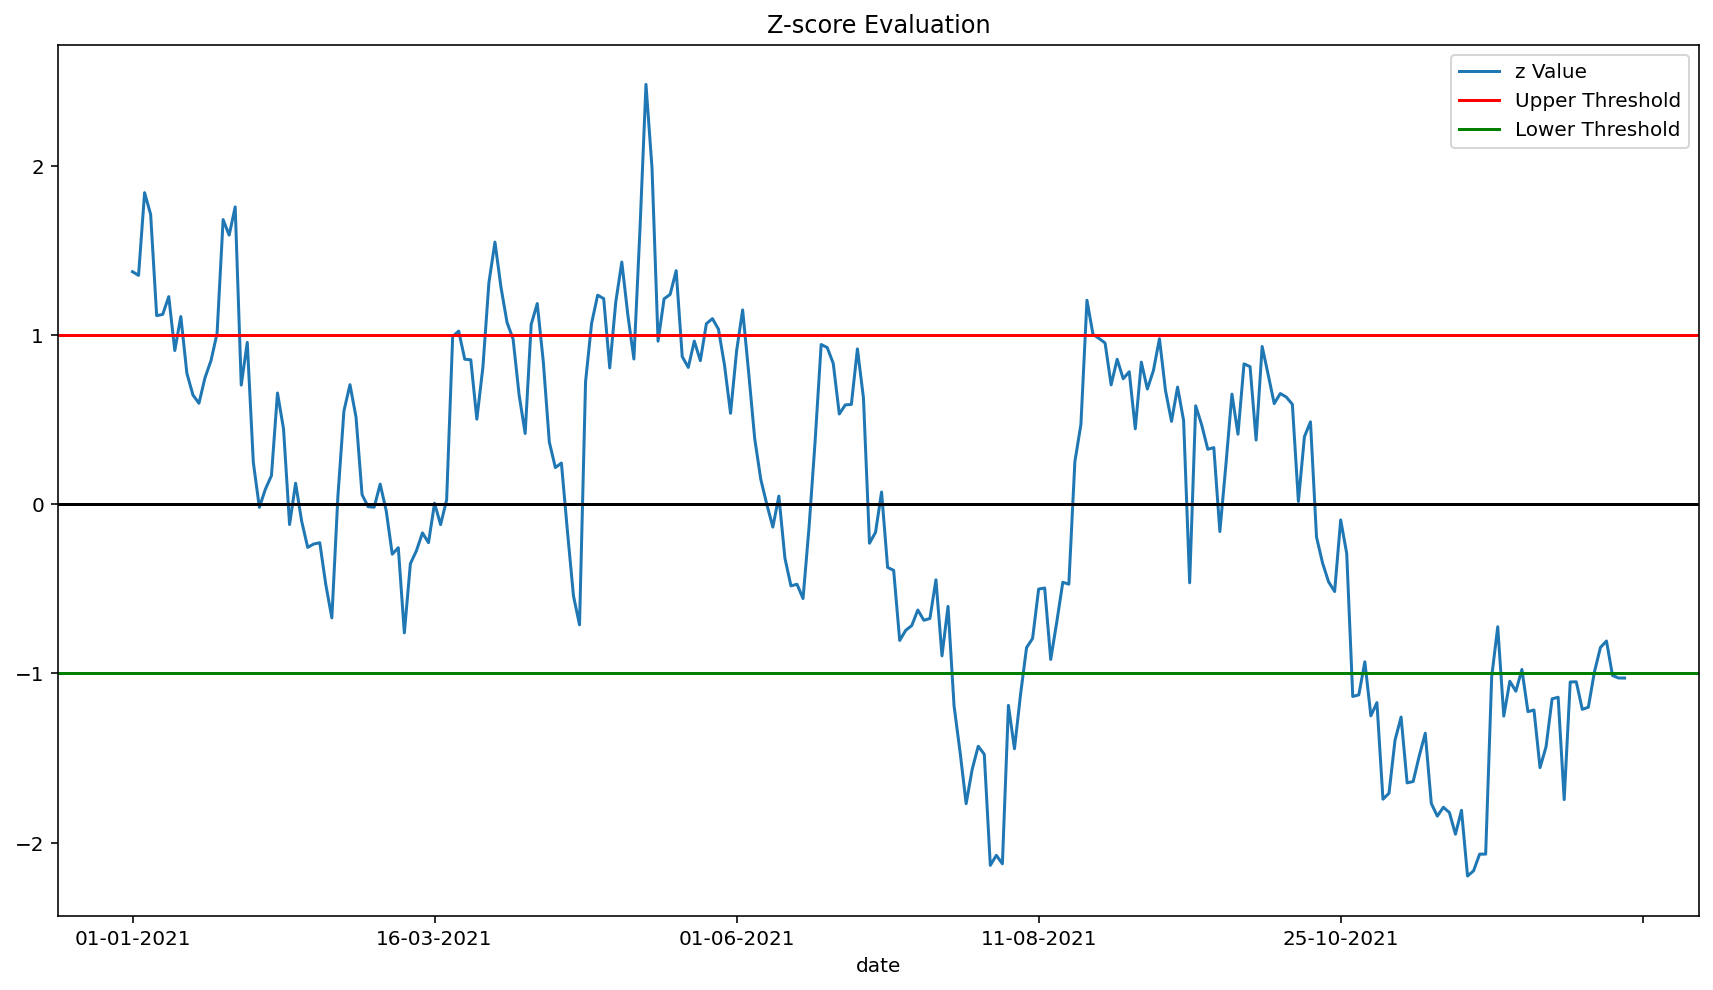

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  2387.550049  534.200012  1.372804            1.0           -1.0   
04-01-2021  2426.500000  543.349976  1.351348            1.0           -1.0   
05-01-2021  2450.550049  538.900024  1.839906            1.0           -1.0   
29-12-2021  2306.850098  566.599976 -1.012923            1.0           -1.0   
30-12-2021  2325.600098  571.549988 -1.027642            1.0           -1.0   
31-12-2021  2360.149902  580.049988 -1.028016            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
29-12-2021         1         1.0        -1        -1.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  2387.550049  534.200012  1.372804            1.0           -1.0   
04-01-2021  2426.500000  543.349976  1.351348            1.0           -1.0   
05-01-2021  2450.550049  538.900024  1.839906            1.0           -1.0   
06-01-2021  2417.300049  534.099976  1.711709            1.0           -1.0   
07-01-2021  2368.850098  535.200012  1.113307            1.0           -1.0   
08-01-2021  2391.199951  540.099976  1.120655            1.0           -1.0   
11-01-2021  2429.100098  546.500000  1.225570            1.0           -1.0   
13-01-2021  2372.350098  536.099976  1.107903            1.0           -1.0   
21-01-2021  2367.649902  537.049988  1.008519            1.0           -1.0   
22-01-2021  2409.350098  532.950012  1.680832            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021        -1         0.0         1         0.0  
08-01-2021        -1         0.0         1         0.0  
11-01-2021        -1         0.0         1         0.0  
13-01-2021        -1        -1.0         1         1.0  
21-01-2021        -1        -1.0         1         1.0  
22-01-2021        -1         0.0         1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  2387.550049  534.200012  1.372804            1.0           -1.0   
12-01-2021  2375.899902  541.000000  0.906981            1.0           -1.0   
13-01-2021  2372.350098  536.099976  1.107903            1.0           -1.0   
14-01-2021  2398.550049  548.950012  0.773067            1.0           -1.0   
21-01-2021  2367.649902  537.049988  1.008519            1.0           -1.0   
03-12-2021  2343.649902  581.349976 -1.252685            1.0           -1.0   
08-12-2021  2340.600098  574.049988 -0.977231            1.0           -1.0   
09-12-2021  2339.750000  579.750000 -1.226318            1.0           -1.0   
24-12-2021  2296.949951  563.700012 -0.992647            1.0           -1.0   
29-12-2021  2306.850098  566.599976 -1.012923            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
12-01-2021         0         1.0         0        -1.0  
13-01-2021        -1        -1.0         1         1.0  
14-01-2021         0         1.0         0        -1.0  
21-01-2021        -1        -1.0         1         1.0  
03-12-2021         1         1.0        -1        -1.0  
08-12-2021         0        -1.0         0         1.0  
09-12-2021         1         1.0        -1        -1.0  
24-12-2021         0        -1.0         0         1.0  
29-12-2021         1         1.0        -1        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

2375.899902    1
2321.699951    1
2339.750000    1
2343.649902    1
2407.100098    1
2396.600098    1
2666.399902    1
2378.149902    1
2363.250000    1
2359.750000    1
2398.550049    1
2328.949951    1
2390.000000    1
2353.750000    1
2454.399902    1
2408.300049    1
2337.300049    1
2300.399902    1
2306.850098    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021  2387.550049  534.200012  1.372804            1.0           -1.0   
04-01-2021  2426.500000  543.349976  1.351348            1.0           -1.0   
05-01-2021  2450.550049  538.900024  1.839906            1.0           -1.0   
06-01-2021  2417.300049  534.099976  1.711709            1.0           -1.0   
07-01-2021  2368.850098  535.200012  1.113307            1.0           -1.0   
...                 ...         ...       ...            ...            ...   
27-12-2021  2301.399902  561.450012 -0.847254            1.0           -1.0   
28-12-2021  2309.100098  562.450012 -0.808875            1.0           -1.0   
29-12-2021  2306.850098  566.599976 -1.012923            1.0           -1.0   
30-12-2021  2325.600098  571.549988 -1.027642            1.0           -1.0   
31-12-2021  2360.149902  580.049988 -1.028016            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021        -1         0.0         1         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         1         1.0        -1        -1.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

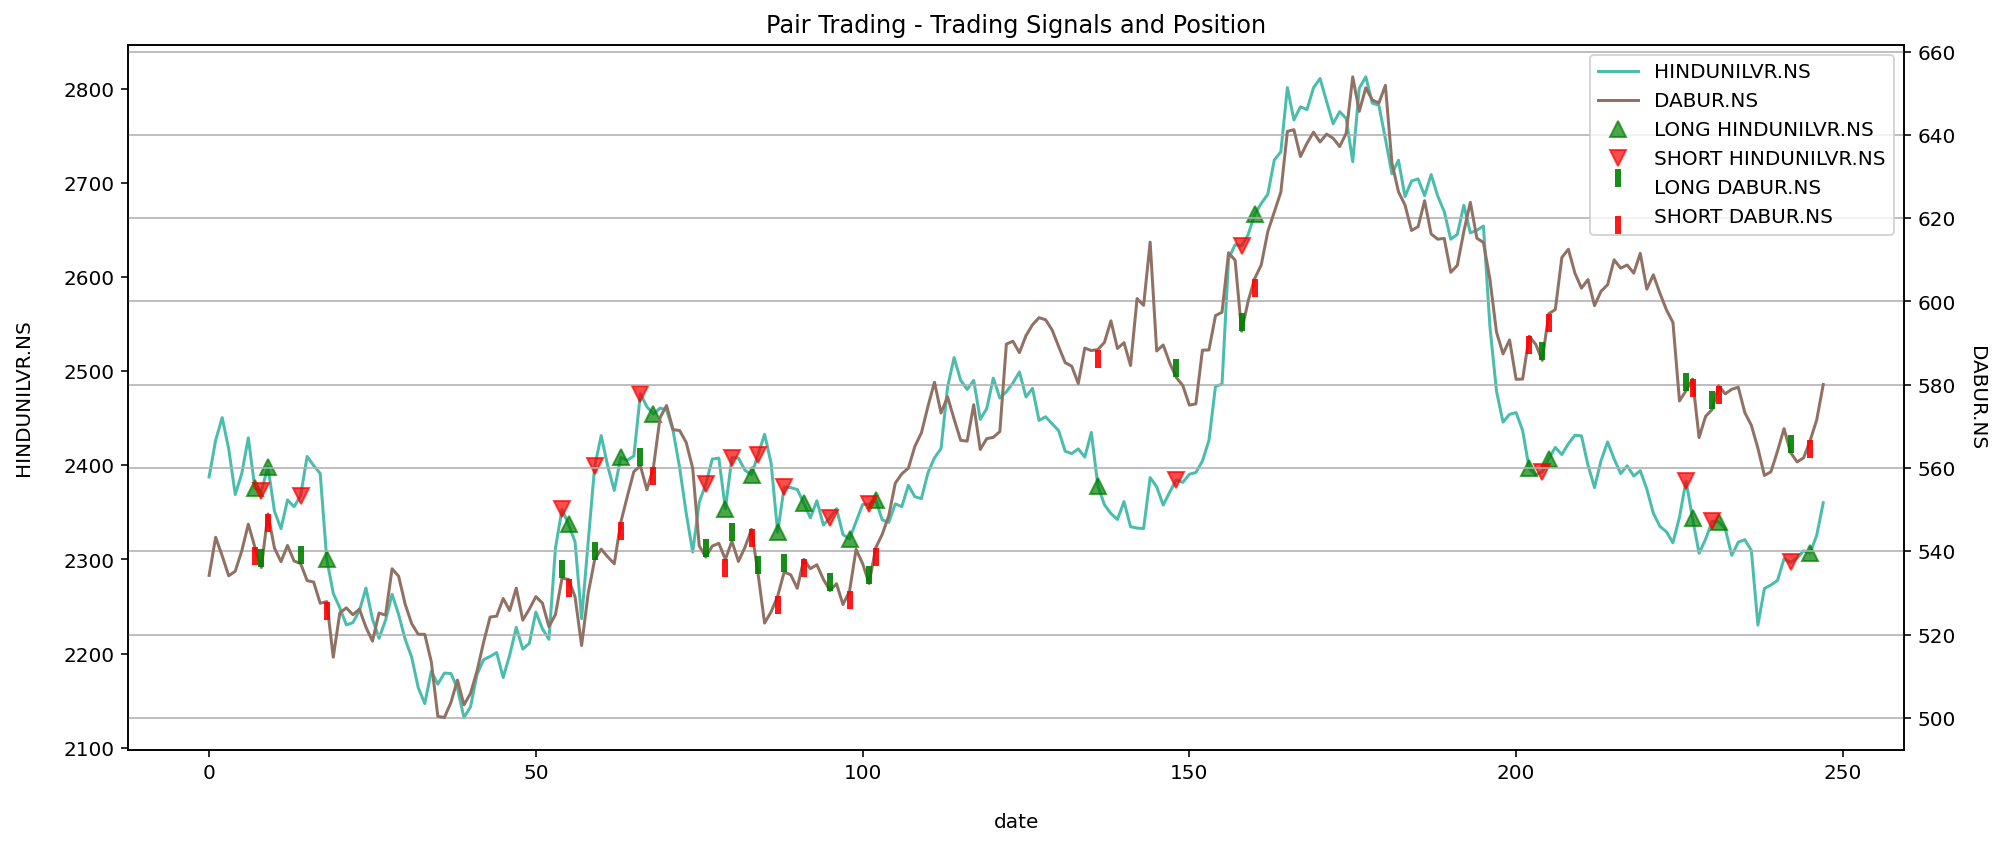

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    2387.550049           NaN            NaN            NaN       NaN   
1    2426.500000       0.00000  100000.000000  100000.000000       NaN   
2    2450.550049       0.00000  100000.000000  100000.000000  0.000000   
3    2417.300049       0.00000  100000.000000  100000.000000  0.000000   
4    2368.850098       0.00000  100000.000000  100000.000000  0.000000   
243  2301.399902   80548.99657   21400.518865  101949.515435  0.001530   
244  2309.100098   80818.50343   21400.518865  102219.022295  0.002644   
245  2306.850098  161479.50686  -59339.234565  102140.272295 -0.000770   
246  2325.600098  162792.00686  -59339.234565  103452.772295  0.012850   
247  2360.149902  165210.49314  -59339.234565  105871.258575  0.023378   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         1.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1         cash1   total asset1   return1  \
0   2387.550049           NaN           NaN            NaN       NaN   
7   2375.899902  83156.496570  16843.503430  100000.000000  0.000000   
8   2372.350098      0.000000  99875.756860   99875.756860 -0.001242   
9   2398.550049  83949.251715  15926.505145   99875.756860  0.000000   
14  2367.649902      0.000000  98794.251715   98794.251715  0.004162   

    positions1  
0          NaN  
7          1.0  
8         -1.0  
9          1.0  
14        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    2387.550049           NaN            NaN            NaN       NaN   
1    2426.500000       0.00000  100000.000000  100000.000000       NaN   
2    2450.550049       0.00000  100000.000000  100000.000000  0.000000   
3    2417.300049       0.00000  100000.000000  100000.000000  0.000000   
4    2368.850098       0.00000  100000.000000  100000.000000  0.000000   
243  2301.399902   80548.99657   21400.518865  101949.515435  0.001530   
244  2309.100098   80818.50343   21400.518865  102219.022295  0.002644   
245  2306.850098  161479.50686  -59339.234565  102140.272295 -0.000770   
246  2325.600098  162792.00686  -59339.234565  103452.772295  0.012850   
247  2360.149902  165210.49314  -59339.234565  105871.258575  0.023378   

     positions1      asset2      holdings2          cash2   total asset2  \
0           NaN  534.200012            NaN            NaN            NaN   
1           0.0  543.349976       0.000000  100000.000000  100000.000000   
2           0.0  538.900024       0.000000  100000.000000  100000.000000   
3           0.0  534.099976       0.000000  100000.000000  100000.000000   
4           0.0  535.200012       0.000000  100000.000000  100000.000000   
243         0.0  561.450012  -85340.401854  195532.027816  110191.625962   
244         0.0  562.450012  -85492.401854  195532.027816  110039.625962   
245         1.0  566.599976 -172246.392582  281655.224107  109408.831525   
246         0.0  571.549988 -173751.196291  281655.224107  107904.027816   
247         0.0  580.049988 -176335.196291  281655.224107  105320.027816   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.003113         0.0  
244 -0.001379         0.0  
245 -0.005732        -1.0  
246 -0.013754         0.0  
247 -0.023947         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1         cash1   total asset1   return1  \
0   2387.550049           NaN           NaN            NaN       NaN   
7   2375.899902  83156.496570  16843.503430  100000.000000  0.000000   
8   2372.350098      0.000000  99875.756860   99875.756860 -0.001242   
9   2398.550049  83949.251715  15926.505145   99875.756860  0.000000   
14  2367.649902      0.000000  98794.251715   98794.251715  0.004162   

    positions1      asset2     holdings2          cash2   total asset2  \
0          NaN  534.200012           NaN            NaN            NaN   
7          1.0  541.000000 -82232.000000  182232.000000  100000.000000   
8         -1.0  536.099976      0.000000  100744.803709  100744.803709   
9          1.0  548.950012 -83440.401854  184185.205563  100744.803709   
14        -1.0  537.049988      0.000000  102553.607418  102553.607418   

     return2  positions2  
0        NaN         NaN  
7   0.000000        -1.0  
8   0.007448         1.0  
9   0.000000        -1.0  
14  0.000890         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

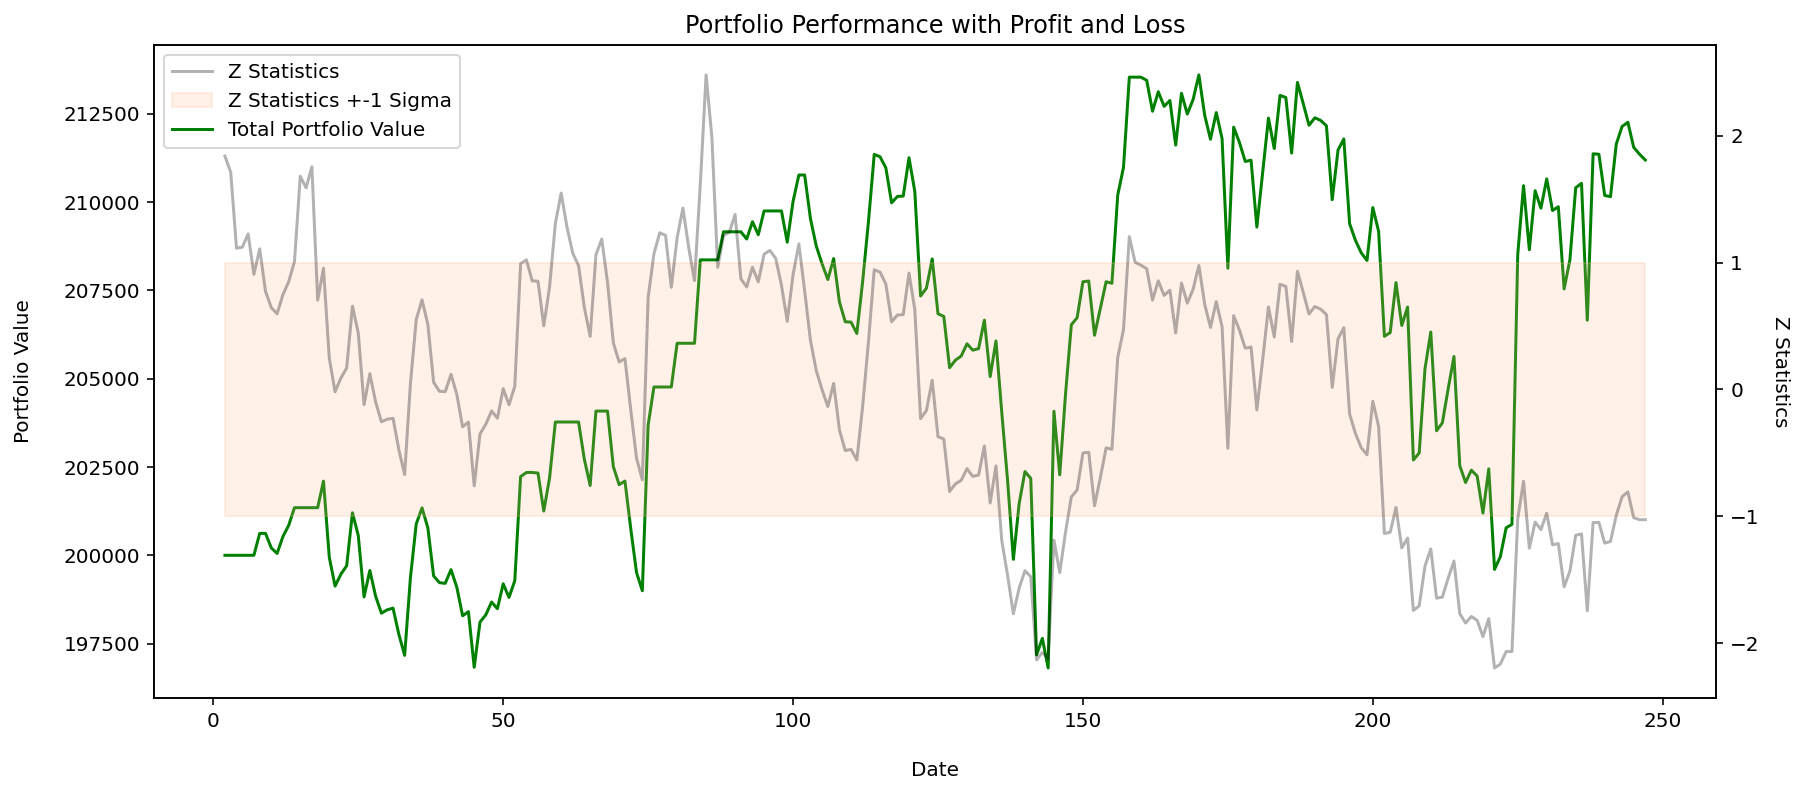

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [46]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

211191.28639099994

In [47]:
profit = final_portfolio - 2*initial_capital
profit

11191.286390999943

In [48]:
roi = (profit/(2*initial_capital))*100  # Overall ROI of the pair trading strategy
roi

5.595643195499972

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [45]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 204.580%
